In [1]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pennylane as pnl
from sklearn import datasets
import matplotlib.pyplot as plt
from pennylane import numpy as pnl_np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc

### Loading the data 

In [2]:
#load the iris dataset
iris = datasets.load_iris()
iris
#create a dataframe with the desire features
features = pd.DataFrame(data=iris.data, columns=['sepal length', 'sepal width', 'petal length', 'petal width'])
selected_features = features[['sepal length', 'petal length']]

# Add the target variable (species) to the DataFrame
selected_features['species'] = iris.target

# Select only the first two classes (0 and 1)
selected_features = selected_features[selected_features['species'].isin([0, 1])]
selected_features

C:\Users\medie\AppData\Local\Temp\ipykernel_13452\2357250441.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features['species'] = iris.target


,sepal length,petal length,species
0,5.1,1.4,0
1,4.9,1.4,0
2,4.7,1.3,0
3,4.6,1.5,0
4,5.0,1.4,0
...,...,...,...
95,5.7,4.2,1
96,5.7,4.2,1
97,6.2,4.3,1
98,5.1,3.0,1


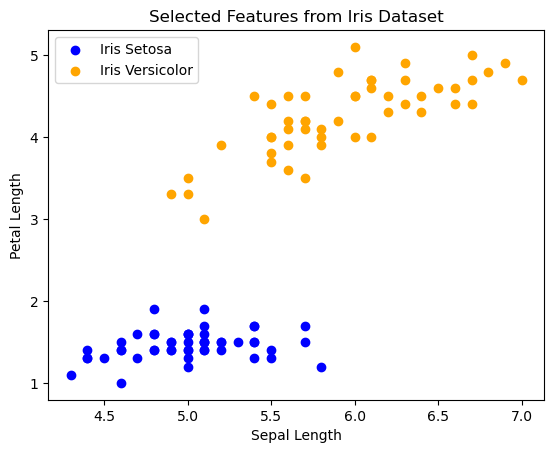

In [3]:
# Plot the selected features
plt.scatter(selected_features[selected_features['species'] == 0]['sepal length'], selected_features[selected_features['species'] == 0]['petal length'], c='blue', label='Iris Setosa')
plt.scatter(selected_features[selected_features['species'] == 1]['sepal length'], selected_features[selected_features['species'] == 1]['petal length'], c='orange', label='Iris Versicolor')
plt.xlabel('Sepal Length')
plt.ylabel('Petal Length')
plt.title('Selected Features from Iris Dataset')
plt.legend()

To improve the training performance and convergence of the dataset, we need to normalize the features. Normalization involves scaling the features of the dataset to a standard range.

In [4]:
# Split the dataset into features (X) and target (y)
X = selected_features[['sepal length', 'petal length']]
y = selected_features['species']

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
#display(print(X_normalized))

# Split the normalized data into training , validation, and test sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_normalized, y, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42)

#transforming the datas into arrays
X_train = np.array(X_train) ; y_train = np.array(y_train)
X_test  = np.array(X_test)  ; y_test  = np.array(y_test)
X_val  = np.array(X_val)  ; y_val  = np.array(y_val)


# Print the shapes of the training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (30, 2) (30,)
Test set shape: (40, 2) (40,)
Validation set shape: (30, 2) (30,)


### Summary

By the end of these operations, the original Iris dataset is divided as follows:

* Training set (`X_train`, `y_train`): Contains 30% of the original data, used to train the model.
* Validation set (`X_val`, `y_val`): Also contains 30% of the original data, used to tune hyperparameters and make decisions about the model to avoid overfitting.
* Test set (`X_test`, `y_test`): Contains the remaining 40% of the original data, used to evaluate the final model's performance and provide an estimate of how well the model is expected to perform on unseen data.


In [9]:
# Create a quantum device with 2 wires as we use 2 features
wires=2
dev = pnl.device("default.qubit", wires)

# Define the quantum circuit
@pnl.qnode(dev)
def quantum_circuit(features, parameters):
    
    # Quantum feature encoding via angle encoding technique
    for i in range(wires):
        pnl.RX(features[i], wires=i)
    
    # Variational circuit
    pnl.Rot(parameters[0], parameters[1], parameters[2], wires=0)
    pnl.Rot(parameters[3], parameters[4], parameters[5], wires=1)
    pnl.CNOT(wires=[0, 1])
    pnl.Rot(parameters[6], parameters[7], parameters[8], wires=0)
    pnl.Rot(parameters[9], parameters[10], parameters[11], wires=1)

    # Measure the expectation value of Pauli-Z on the first qubit
    return pnl.expval(pnl.PauliZ(0))

In [10]:
#calculate the probability by normalizing the expectation value to the range [0, 1]
def get_probability(features, parameters):
    exp_val = quantum_circuit(features, parameters)
    return (exp_val + 1) / 2 # Adding 1 to the expectation value ensures that it is non-negative, 
                            #and dividing by 2 scales it to the range [0, 1]

We now use a mean squared error (MSE) cost function to measure the average squared difference between the predicted values and the actual labels.

Minimizing this cost function during the training process will us finding the optimal values for the parameters that minimize the overall prediction error.

In [7]:
def cost_function(parameters, features, labels):
    predictions = pnl_np.array([get_probability(f, parameters) for f in features])
    return pnl_np.mean((predictions - labels) ** 2)  # Using MSE for simplicity

We now train our model using a gradient descent optimizer with a step size or learning rate of 0.4

In [8]:
# Initialize parameters
parameters = pnl_np.random.random(12, requires_grad=True)

# Optimizer
opt = pnl.GradientDescentOptimizer(stepsize=0.4)

epochs = 50
batch_size = 5

train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    total_train_loss = 0

    # Batch processing for training
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        
        # Update parameters and calculate batch loss
        parameters, batch_loss = opt.step_and_cost(lambda v: cost_function(v, X_batch, y_batch), parameters)
        total_train_loss += batch_loss * len(X_batch)
    
    # Average training loss over all batches
    avg_train_loss = total_train_loss / len(X_train)
    train_losses.append(avg_train_loss)

    # Making predictions for the entire training and validation sets
    predictions_train = pnl_np.array([quantum_circuit(x, parameters) for x in X_train])
    predictions_val = pnl_np.array([quantum_circuit(x, parameters) for x in X_val])

    # Calculating validation loss
    val_loss = cost_function(parameters, X_val, y_val)
    val_losses.append(val_loss)

    # Converting predictions to binary outcomes for classification
    binary_predictions_train = pnl_np.where(predictions_train > 0.5, 1, 0)
    binary_predictions_val = pnl_np.where(predictions_val > 0.5, 1, 0)
#predictions_train > 0.5 and predictions_val > 0.5 serve as decision thresholds to
#categorize the probability outputs into two classes. If a prediction probability is greater
#than 0.5, it is classified as class 1 (versicolour); otherwise, it is classified as class 0 (setosa)
    
    
    # Calculating accuracies
    train_accuracy = pnl_np.mean(binary_predictions_train == y_train)
    train_accuracies.append(train_accuracy)
    val_accuracy = pnl_np.mean(binary_predictions_val == y_val)
    val_accuracies.append(val_accuracy)

    # Calculating F1 score for the validation set
    f1_val = f1_score(y_val, binary_predictions_val)
    val_f1_scores.append(f1_val)

    # Printing metrics for each epoch
    print(f'Epoch: {epoch + 1}, Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}, '
          f'Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {f1_val:.2f}')

Epoch: 1, Train Acc: 0.53, Val Acc: 0.47, Train Loss: 0.3641, Val Loss: 0.3146, Val F1: 0.56
Epoch: 2, Train Acc: 0.63, Val Acc: 0.67, Train Loss: 0.2765, Val Loss: 0.2102, Val F1: 0.64
Epoch: 3, Train Acc: 0.67, Val Acc: 0.83, Train Loss: 0.1592, Val Loss: 0.1275, Val F1: 0.84
Epoch: 4, Train Acc: 0.77, Val Acc: 0.77, Train Loss: 0.1035, Val Loss: 0.0958, Val F1: 0.76
Epoch: 5, Train Acc: 0.80, Val Acc: 0.77, Train Loss: 0.0860, Val Loss: 0.0816, Val F1: 0.74
Epoch: 6, Train Acc: 0.80, Val Acc: 0.77, Train Loss: 0.0779, Val Loss: 0.0730, Val F1: 0.74
Epoch: 7, Train Acc: 0.80, Val Acc: 0.77, Train Loss: 0.0726, Val Loss: 0.0669, Val F1: 0.74
Epoch: 8, Train Acc: 0.83, Val Acc: 0.83, Train Loss: 0.0687, Val Loss: 0.0623, Val F1: 0.83
Epoch: 9, Train Acc: 0.83, Val Acc: 0.83, Train Loss: 0.0658, Val Loss: 0.0590, Val F1: 0.83
Epoch: 10, Train Acc: 0.83, Val Acc: 0.83, Train Loss: 0.0635, Val Loss: 0.0564, Val F1: 0.83
Epoch: 11, Train Acc: 0.83, Val Acc: 0.83, Train Loss: 0.0618, Val Lo

### Interpretation of the results

* Epoch: The number of the epoch.

* Train Acc: The training accuracy achieved at the end of the epoch.

* Val Acc: The validation accuracy achieved at the end of the epoch.

* Train Loss: The training loss (error) achieved at the end of the epoch.

* Val Loss: The validation loss (error) achieved at the end of the epoch.

* Val F1: The validation F1 score achieved at the end of the epoch.
    
    
***The training accuracy and loss indicate how well the model is performing on the training data, while the validation accuracy and loss provide an estimate of the model's performance on unseen data.***

From our output, we can see that the model achieves a high accuracy and low loss on both the training and validation sets. This suggests that the model is learning well and generalizing to unseen data. The validation accuracy and loss remain consistent throughout the epochs, indicating that the model is not overfitting to the training data. Thus, our model is able to accurately classify Iris flowers as either setosa or versicolor based on their petal and sepal lengths. The high validation accuracy and low validation loss indicate that the model is performing well and can be used for classification tasks.



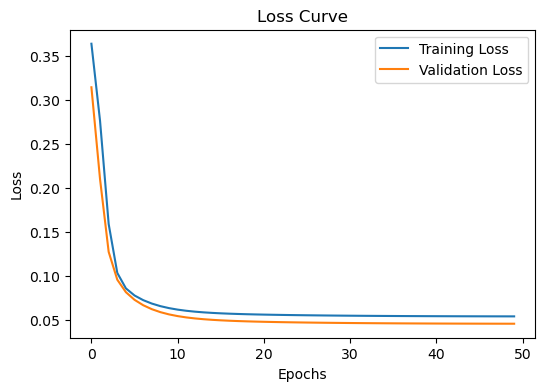

In [9]:
#plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From this Loss curve, we can see that the model is learning from the data, as evidenced by the decrease in loss.

The model does not appear to be overfitting during the range of epochs shown, since the
loss continues to decrease or remains stable, rather than increasing (which could indicate
that the model is starting to memorize the training data rather than learning generalizable
patterns).

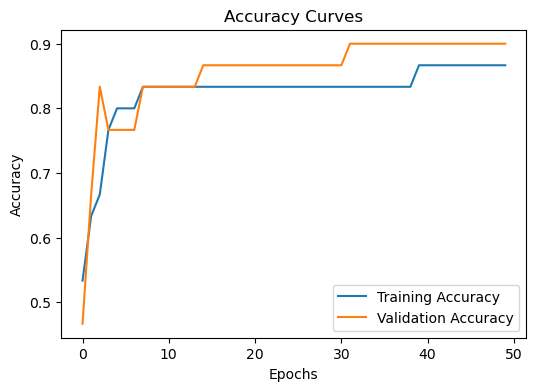

In [10]:
# Accuracy Curves
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From this accuracy curve, we can see that in the initial few epochs, the accuracy rises quickly, indicating that the model is picking up new information from the training set.The model is starting to stabilize in its predictions when, following the first sharp spike, the accuracy growth slows down and the curve begins to plateau.
The model improves its accuracy in identifying the validation set during the first few epochs rather quickly.

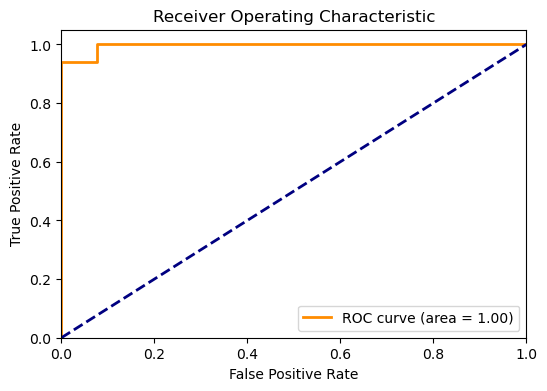

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, predictions_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

From this ROC curve, we can see that the model is performing good in distinguishing between the positive and negative classes as the Area under the ROC curve (AUC) is high ie =1. 


In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, predictions_val)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

From this Precision_Recall curve, we can see that the precision has a higher value (1) which means a lower false positive rate and a high recall (1), meaning that our classifier is returning more relevant results. So, the model is performing well the classification of the iris flowers into setosa and versicolour

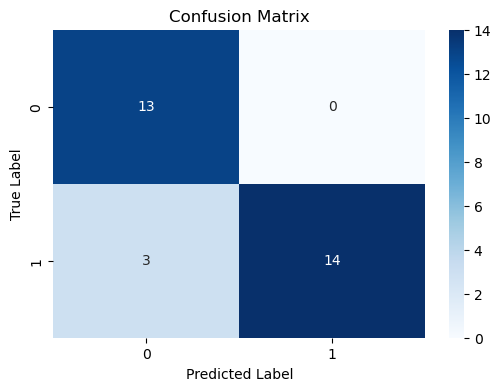

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_val, binary_predictions_val)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix, we can see that:

* Class 0 had 13 true predictions and no false predictions.
* Class 1 had 14 true predictions but was incorrectly predicted 3 times as class 0.

This model appears to work well, especially when it comes to class 0 prediction. It did, however, mistakenly classify class 1 as class 0 in a few instances. However, no occurrences of class 0 were incorrectly classified as class 1 by it.

### References

* PennyLane tutorials: https://pennylane.ai/qml/demonstrations/

* https://www.nature.com/articles/s41598-023-46469-2#Tab1

* https://github.com/sophchoe/Binary_Classification_Pennylane_Keras

* https://doi.org/10.1038/s41598-023-46469-2

* QClass23/24 materials